# HMI Project

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

### Loding Data from CSV with encoding fallback

In [42]:
file_path = 'Final-results-survey684674-with-code-name-column.csv'
for enc in ['utf-8', 'cp1252', 'ISO-8859-1']:
    try:
        df = pd.read_csv(file_path, encoding=enc, engine='python')
        print(f"Loaded with encoding: {enc}")
        break
    except UnicodeDecodeError:
        pass
else:
    raise Exception("Failed to load file using common encodings.")

Loaded with encoding: cp1252


#### Pre-Processing - Defining which question belongs to which metric

In [43]:
idx_attrak = {
    'PQ': [1, 5, 8, 10, 20, 27, 28],
    'HQ_I': [2, 6, 11, 13, 14, 15, 16],
    'HQ_S': [4, 12, 17, 18, 22, 23, 24],
    'ATT': [3, 7, 9, 19, 21, 25, 26]
}
idx_scm = {
    'Warmth': [1, 2, 3, 4],
    'Competence': [5, 6, 7, 8, 9]
}
# --------------------------
# 2. Column prefixes
# --------------------------
prefix_map = {
    'ChatGPT': 'CHATGPTA1[SQ',
    'Duolingo': 'DULINGOA2[SQ',
    'Smartwatch': 'SWA2[SQ',
    'DB Navigator': 'DBA2[SQ',
    'Spotify': 'SA2[SQ',
    'Airfryer': 'AFA2[SQ',
    'Laptop': 'LA2[SQ',
    'Robot Vacuum': 'RVA2[SQ'
}
scm_map = {
    'ChatGPT': 'CHATS2[SQ',
    'Duolingo': 'DLS2[SQ',
    'Smartwatch': 'SWS2[SQ',
    'DB Navigator': 'DBS2[SQ',
    'Spotify': 'SS2[SQ',
    'Airfryer': 'AFS2[SQ',
    'Laptop': 'LS2[SQ',
    'Robot Vacuum': 'RVS2[SQ'
}
products = list(prefix_map.keys())

#### Helper function

In [44]:
def build_cols(prefix, nums):
    return [f"{prefix}{num:03d}]" for num in nums]

##### Computing Metrics

In [45]:
metrics = ['PQ', 'HQ_I', 'HQ_S', 'ATT', 'Warmth', 'Competence', 'Engagement']
for p in products:
    for metric, nums in idx_attrak.items():
        cols = build_cols(prefix_map[p], nums)
        df[f"{metric}_{p}"] = df[cols].mean(axis=1)
    for metric, nums in idx_scm.items():
        cols = build_cols(scm_map[p], nums)
        df[f"{metric}_raw_{p}"] = df[cols].mean(axis=1)
        df[f"{metric}_{p}"] = ((df[f"{metric}_raw_{p}"] - 1) / 4) * 6 + 1
    df[f"Engagement_{p}"] = df[f"ATT_{p}"]

#### Cleaning Data

In [46]:

# --------------------------
# Drop Incomplete Rows
# --------------------------

all_columns = [f"{m}_{p}" for p in products for m in metrics]
df_clean = df.dropna(subset=all_columns)

#### Descriptive Stats

In [63]:
stats = {
    p: df_clean[[f"{m}_{p}" for m in metrics]].agg(['mean', 'std'])
    for p in products
}
stats_df = pd.concat(stats, axis=1)
stats_df.to_csv('app_stats.csv')
print("Saved descriptive stats to 'app_stats.csv'")

Saved descriptive stats to 'app_stats.csv'


#### Correlation Matrix

In [64]:
corr = df_clean[all_columns].corr()
corr.to_csv('correlation_matrix.csv')
print("Saved correlation matrix to 'correlation_matrix.csv'")


Saved correlation matrix to 'correlation_matrix.csv'


#### Pearson Correlation Tests

In [65]:
print("\nPearson Correlations vs Engagement per Product:")
for p in products:
    for m in ['PQ', 'HQ_I', 'HQ_S', 'ATT', 'Warmth', 'Competence']:
        try:
            r, pval = pearsonr(df_clean[f"{m}_{p}"], df_clean[f"Engagement_{p}"])
            print(f"{p}: {m} ↔ Engagement | r = {r:.2f}, p = {pval:.3f}")
        except Exception as e:
            print(f"Error for {p} - {m}: {e}")



Pearson Correlations vs Engagement per Product:
ChatGPT: PQ ↔ Engagement | r = 0.53, p = 0.000
ChatGPT: HQ_I ↔ Engagement | r = 0.37, p = 0.005
ChatGPT: HQ_S ↔ Engagement | r = 0.70, p = 0.000
ChatGPT: ATT ↔ Engagement | r = 1.00, p = 0.000
ChatGPT: Warmth ↔ Engagement | r = -0.27, p = 0.050
ChatGPT: Competence ↔ Engagement | r = -0.17, p = 0.204
Duolingo: PQ ↔ Engagement | r = 0.69, p = 0.000
Duolingo: HQ_I ↔ Engagement | r = 0.69, p = 0.000
Duolingo: HQ_S ↔ Engagement | r = 0.72, p = 0.000
Duolingo: ATT ↔ Engagement | r = 1.00, p = 0.000
Duolingo: Warmth ↔ Engagement | r = -0.07, p = 0.590
Duolingo: Competence ↔ Engagement | r = -0.09, p = 0.522
Smartwatch: PQ ↔ Engagement | r = 0.74, p = 0.000
Smartwatch: HQ_I ↔ Engagement | r = 0.56, p = 0.000
Smartwatch: HQ_S ↔ Engagement | r = 0.69, p = 0.000
Smartwatch: ATT ↔ Engagement | r = 1.00, p = 0.000
Smartwatch: Warmth ↔ Engagement | r = -0.01, p = 0.938
Smartwatch: Competence ↔ Engagement | r = -0.22, p = 0.112
DB Navigator: PQ ↔ Engag

#### Correlation Heatmap

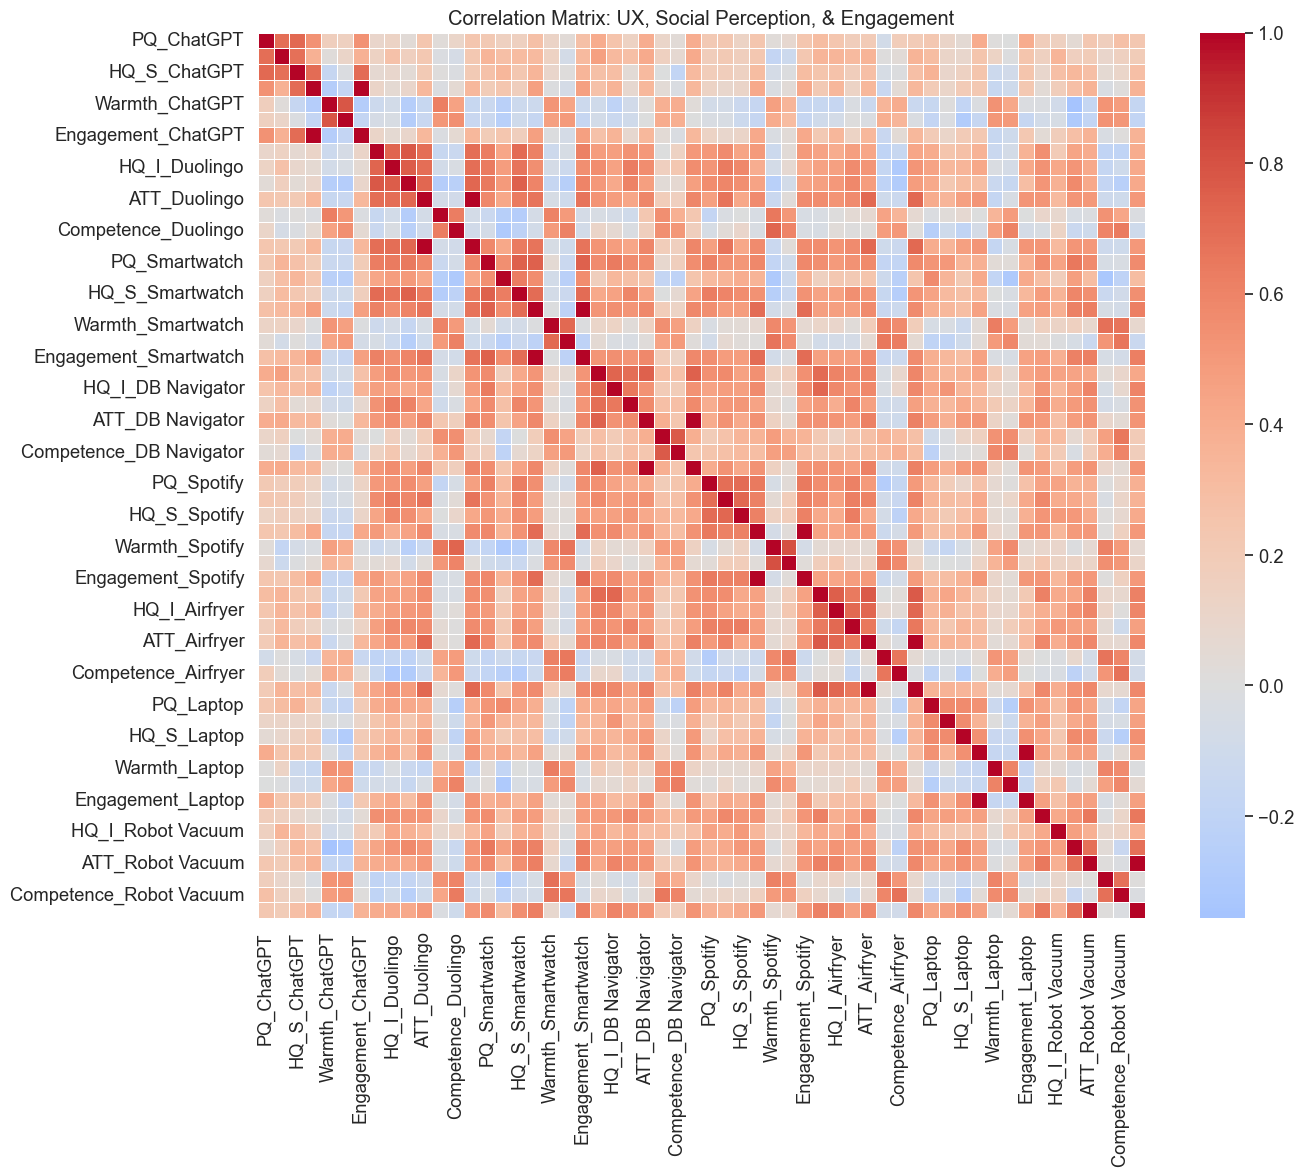

In [66]:
plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix: UX, Social Perception, & Engagement')
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

#### Bar Chart: Mean Scores

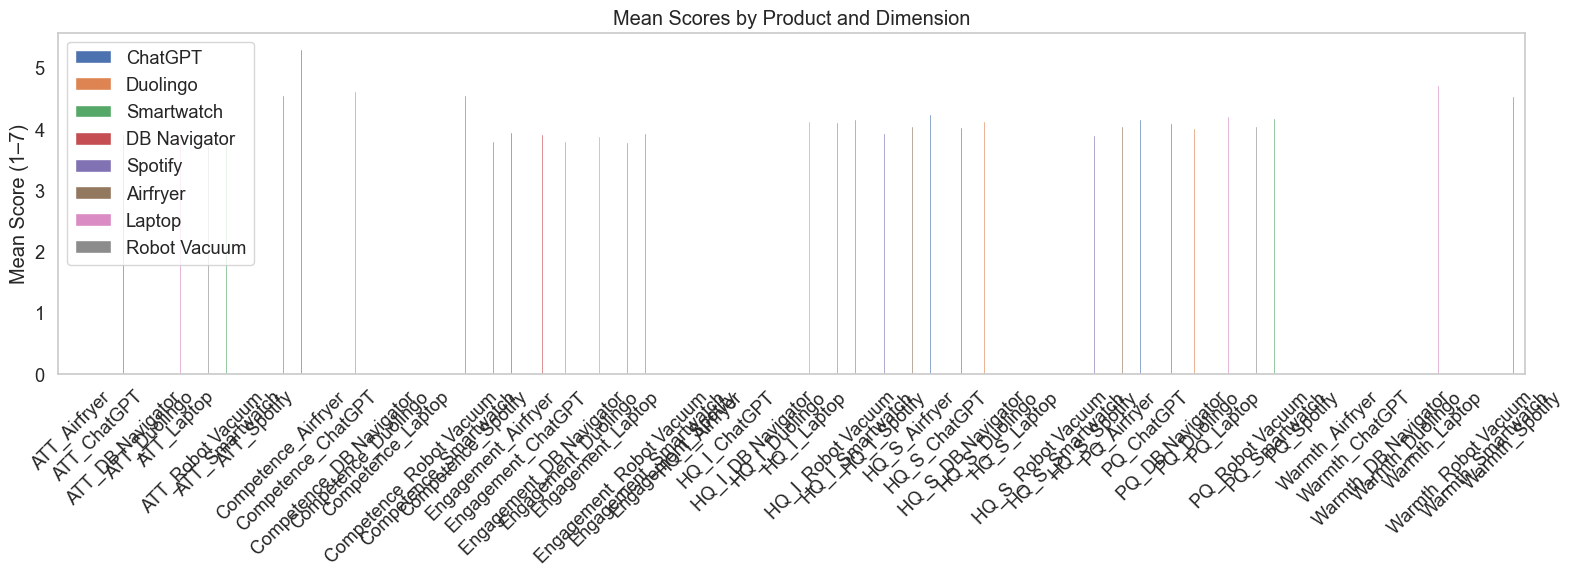

In [68]:
mean_series = stats_df.loc['mean']
mean_series = mean_series.unstack().T
mean_series.plot(kind='bar', figsize=(16, 6))
plt.title('Mean Scores by Product and Dimension')
plt.ylabel('Mean Score (1–7)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(False)
plt.savefig('mean_scores_bar.png')
plt.show()

### Additional Visualizations

#### Histogram of Engagement Scores per Product

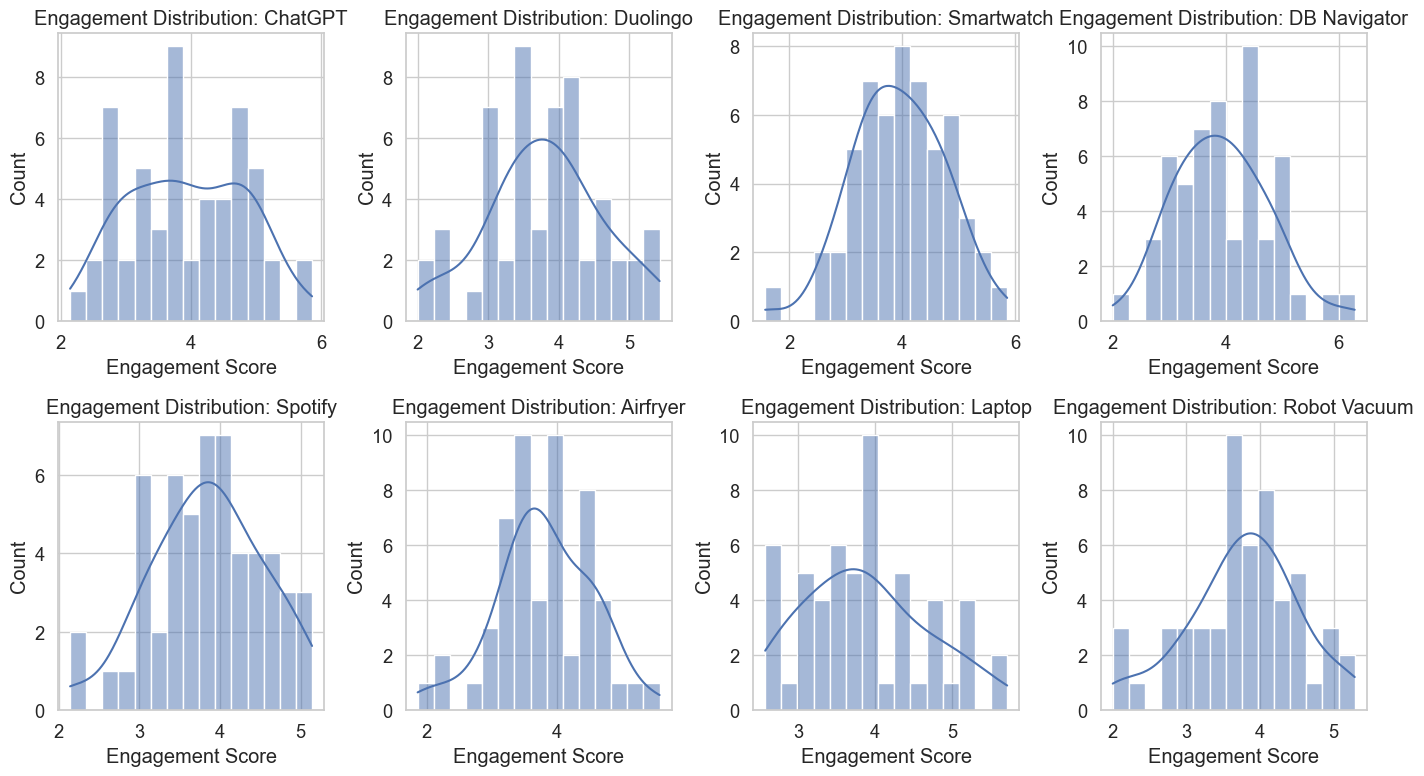

In [52]:
plt.figure(figsize=(14, 8))
for i, p in enumerate(products, 1):
    plt.subplot(2, 4, i)
    sns.histplot(df_clean[f'Engagement_{p}'], bins=15, kde=True)
    plt.title(f'Engagement Distribution: {p}')
    plt.xlabel('Engagement Score')
    plt.ylabel('Count')
plt.tight_layout()
plt.savefig('engagement_histograms.png')
plt.show()

#### Missing Data Summary

In [53]:
print("\nMissing Data Summary (per product & metric):")
missing_summary = {}
for p in products:
    for metric in metrics:
        col = f"{metric}_{p}"
        missing_count = df[col].isna().sum()
        missing_summary[(p, metric)] = missing_count
        print(f"{p} - {metric}: Missing {missing_count} / {len(df)}")

missing_df = pd.Series(missing_summary).unstack()
missing_df.to_csv('missing_data_summary.csv')
print("Saved missing data summary to 'missing_data_summary.csv'")
missing_df.head()




Missing Data Summary (per product & metric):
ChatGPT - PQ: Missing 0 / 55
ChatGPT - HQ_I: Missing 0 / 55
ChatGPT - HQ_S: Missing 0 / 55
ChatGPT - ATT: Missing 0 / 55
ChatGPT - Warmth: Missing 0 / 55
ChatGPT - Competence: Missing 0 / 55
ChatGPT - Engagement: Missing 0 / 55
Duolingo - PQ: Missing 0 / 55
Duolingo - HQ_I: Missing 0 / 55
Duolingo - HQ_S: Missing 0 / 55
Duolingo - ATT: Missing 0 / 55
Duolingo - Warmth: Missing 0 / 55
Duolingo - Competence: Missing 0 / 55
Duolingo - Engagement: Missing 0 / 55
Smartwatch - PQ: Missing 0 / 55
Smartwatch - HQ_I: Missing 0 / 55
Smartwatch - HQ_S: Missing 0 / 55
Smartwatch - ATT: Missing 0 / 55
Smartwatch - Warmth: Missing 0 / 55
Smartwatch - Competence: Missing 0 / 55
Smartwatch - Engagement: Missing 0 / 55
DB Navigator - PQ: Missing 0 / 55
DB Navigator - HQ_I: Missing 0 / 55
DB Navigator - HQ_S: Missing 0 / 55
DB Navigator - ATT: Missing 0 / 55
DB Navigator - Warmth: Missing 0 / 55
DB Navigator - Competence: Missing 0 / 55
DB Navigator - Engage

,ATT,Competence,Engagement,HQ_I,HQ_S,PQ,Warmth
Airfryer,0,0,0,0,0,0,0
ChatGPT,0,0,0,0,0,0,0
DB Navigator,0,0,0,0,0,0,0
Duolingo,0,0,0,0,0,0,0
Laptop,0,0,0,0,0,0,0


#### Save Cleaned Data

In [54]:
df_clean.to_csv('cleaned_data.csv', index=False)
print("Saved cleaned data to 'cleaned_data.csv'")

Saved cleaned data to 'cleaned_data.csv'


#### Printing columns : Which columns used for product analysis

In [55]:
for p in products:
    print(f"\nProduct: {p}")
    for metric, nums in idx_attrak.items():
        cols = build_cols(prefix_map[p], nums)
        print(f"{metric}: {cols}")
    for metric, nums in idx_scm.items():
        cols = build_cols(scm_map[p], nums)
        print(f"{metric}: {cols}")


Product: ChatGPT
PQ: ['CHATGPTA1[SQ001]', 'CHATGPTA1[SQ005]', 'CHATGPTA1[SQ008]', 'CHATGPTA1[SQ010]', 'CHATGPTA1[SQ020]', 'CHATGPTA1[SQ027]', 'CHATGPTA1[SQ028]']
HQ_I: ['CHATGPTA1[SQ002]', 'CHATGPTA1[SQ006]', 'CHATGPTA1[SQ011]', 'CHATGPTA1[SQ013]', 'CHATGPTA1[SQ014]', 'CHATGPTA1[SQ015]', 'CHATGPTA1[SQ016]']
HQ_S: ['CHATGPTA1[SQ004]', 'CHATGPTA1[SQ012]', 'CHATGPTA1[SQ017]', 'CHATGPTA1[SQ018]', 'CHATGPTA1[SQ022]', 'CHATGPTA1[SQ023]', 'CHATGPTA1[SQ024]']
ATT: ['CHATGPTA1[SQ003]', 'CHATGPTA1[SQ007]', 'CHATGPTA1[SQ009]', 'CHATGPTA1[SQ019]', 'CHATGPTA1[SQ021]', 'CHATGPTA1[SQ025]', 'CHATGPTA1[SQ026]']
Warmth: ['CHATS2[SQ001]', 'CHATS2[SQ002]', 'CHATS2[SQ003]', 'CHATS2[SQ004]']
Competence: ['CHATS2[SQ005]', 'CHATS2[SQ006]', 'CHATS2[SQ007]', 'CHATS2[SQ008]', 'CHATS2[SQ009]']

Product: Duolingo
PQ: ['DULINGOA2[SQ001]', 'DULINGOA2[SQ005]', 'DULINGOA2[SQ008]', 'DULINGOA2[SQ010]', 'DULINGOA2[SQ020]', 'DULINGOA2[SQ027]', 'DULINGOA2[SQ028]']
HQ_I: ['DULINGOA2[SQ002]', 'DULINGOA2[SQ006]', 'DULINGOA2[

## Scatter Plots

### Scatter Plot 1: PQ vs HQ (HQ = HQ_I + HQ_S average)

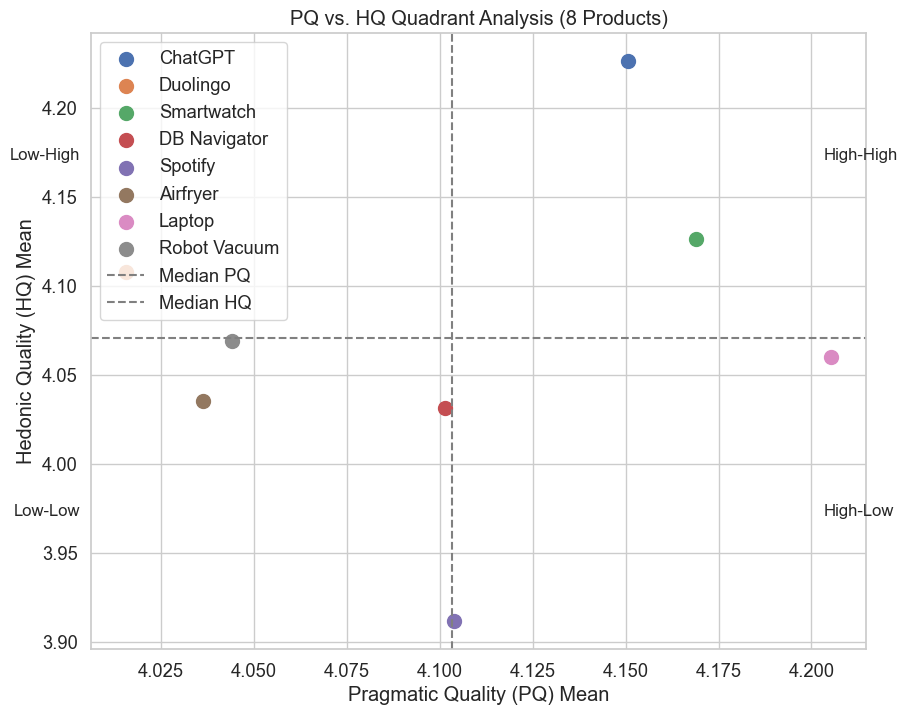

In [56]:
plt.figure(figsize=(10, 8))
for product in products:
    pq_mean = df_clean[f'PQ_{product}'].mean()
    hq_mean = (df_clean[f'HQ_I_{product}'].mean() + df_clean[f'HQ_S_{product}'].mean()) / 2
    plt.scatter(pq_mean, hq_mean, s=100, label=product)

pq_median = df_clean[[f'PQ_{product}' for product in products]].mean().mean()
hq_median = (
    df_clean[[f'HQ_I_{product}' for product in products]].mean().mean() +
    df_clean[[f'HQ_S_{product}' for product in products]].mean().mean()
) / 2
plt.axvline(pq_median, color='gray', linestyle='--', label='Median PQ')
plt.axhline(hq_median, color='gray', linestyle='--', label='Median HQ')

plt.text(pq_median + 0.1, hq_median + 0.1, 'High-High', fontsize=12, ha='left')
plt.text(pq_median + 0.1, hq_median - 0.1, 'High-Low', fontsize=12, ha='left')
plt.text(pq_median - 0.1, hq_median + 0.1, 'Low-High', fontsize=12, ha='right')
plt.text(pq_median - 0.1, hq_median - 0.1, 'Low-Low', fontsize=12, ha='right')

plt.xlabel('Pragmatic Quality (PQ) Mean')
plt.ylabel('Hedonic Quality (HQ) Mean')
plt.title('PQ vs. HQ Quadrant Analysis (8 Products)')
plt.legend()
plt.grid(True)
plt.savefig('pq_vs_hq_scatter.png')
plt.show()

### Scatter Plot 2: Competence VS Warmth 

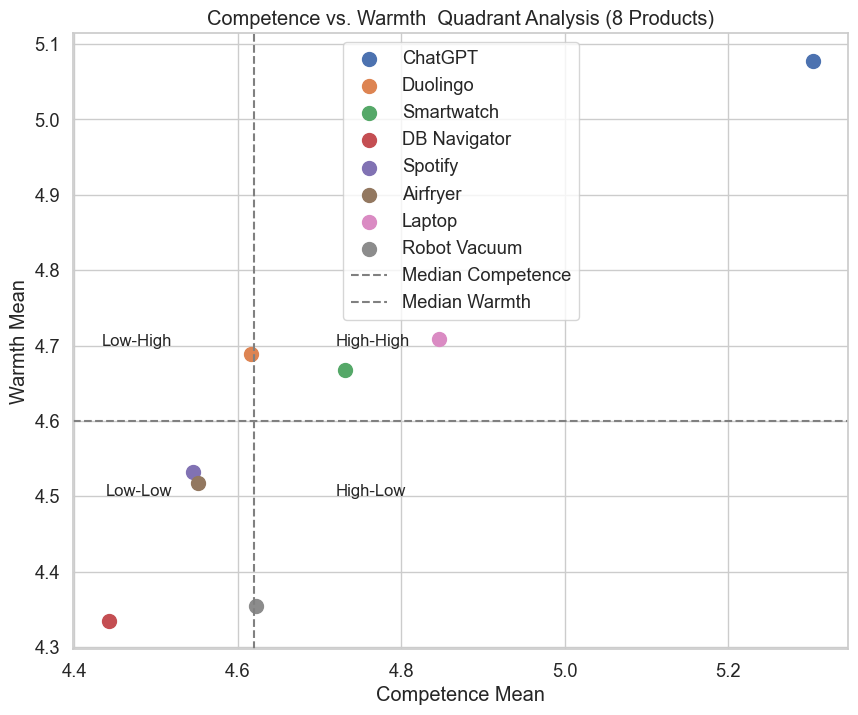

In [57]:
plt.figure(figsize=(10, 8))
for product in products:
    warmth_mean = df_clean[f'Warmth_{product}'].mean()
    competence_mean = df_clean[f'Competence_{product}'].mean()
    plt.scatter(competence_mean, warmth_mean,  s=100, label=product)

warmth_median = df_clean[[f'Warmth_{product}' for product in products]].mean().median()
competence_median = df_clean[[f'Competence_{product}' for product in products]].mean().median()


plt.axvline(competence_median, color='gray', linestyle='--', label='Median Competence')
plt.axhline(warmth_median, color='gray', linestyle='--', label='Median Warmth')

# ✅ Fix quadrant labels
plt.text(competence_median + 0.1, warmth_median + 0.1,  'High-High', fontsize=12, ha='left')
plt.text(competence_median - 0.1, warmth_median + 0.1, 'Low-High',  fontsize=12, ha='right')
plt.text(competence_median + 0.1, warmth_median - 0.1, 'High-Low',  fontsize=12, ha='left')
plt.text(competence_median - 0.1, warmth_median - 0.1, 'Low-Low',   fontsize=12, ha='right')

plt.ylabel('Warmth Mean')
plt.xlabel('Competence Mean')
plt.title('Competence vs. Warmth  Quadrant Analysis (8 Products)')
plt.legend()
plt.grid(True)

plt.savefig('warmth_vs_competence_scatter.png')
plt.show()

### Scatter Plot 3: PQ VS Competence

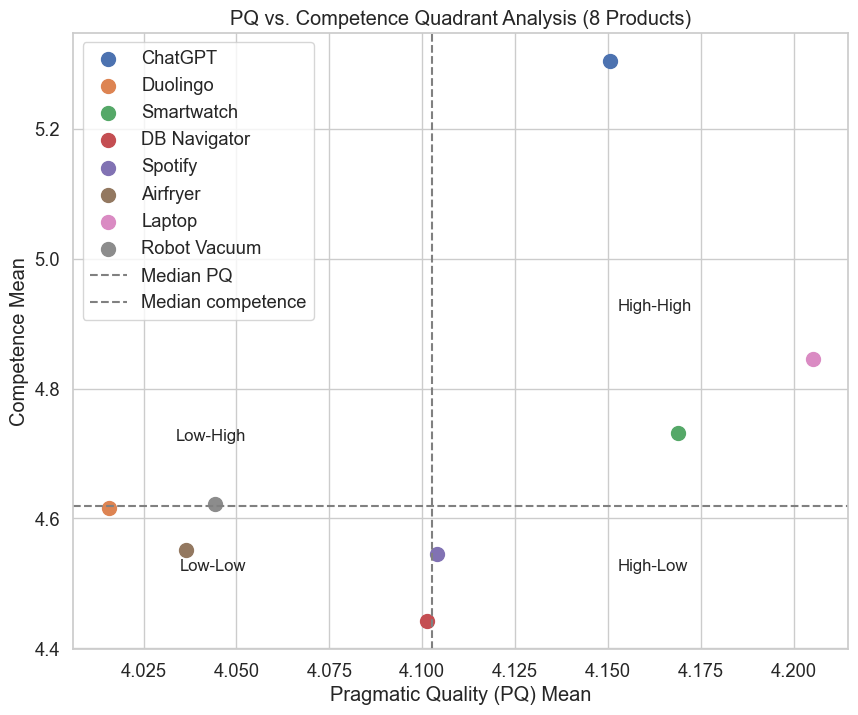

In [58]:

plt.figure(figsize=(10, 8))
for product in products:
    pq_mean = df_clean[f'PQ_{product}'].mean()
    competence_mean = df_clean[f'Competence_{product}'].mean()
    plt.scatter(pq_mean, competence_mean, s=100, label=product)

pq_median = df_clean[[f'PQ_{product}' for product in products]].mean().median()
competence_median = df_clean[[f'Competence_{product}' for product in products]].mean().median()
plt.axvline(pq_median, color='gray', linestyle='--', label='Median PQ')
plt.axhline(competence_median, color='gray', linestyle='--', label='Median competence')

plt.text(pq_median + 0.05, competence_median + 0.3, 'High-High', fontsize=12, ha='left')
plt.text(pq_median + 0.05, competence_median - 0.1, 'High-Low', fontsize=12, ha='left')
plt.text(pq_median - 0.05, competence_median + 0.1, 'Low-High', fontsize=12, ha='right')
plt.text(pq_median - 0.05, competence_median - 0.1, 'Low-Low', fontsize=12, ha='right')

plt.xlabel('Pragmatic Quality (PQ) Mean')
plt.ylabel('Competence Mean')
plt.title('PQ vs. Competence Quadrant Analysis (8 Products)')

plt.legend()
plt.grid(True)
plt.savefig('pq_vs_Comp_scatter.png')
plt.show()



### Scatter Plot 4: HQ VS Warmth

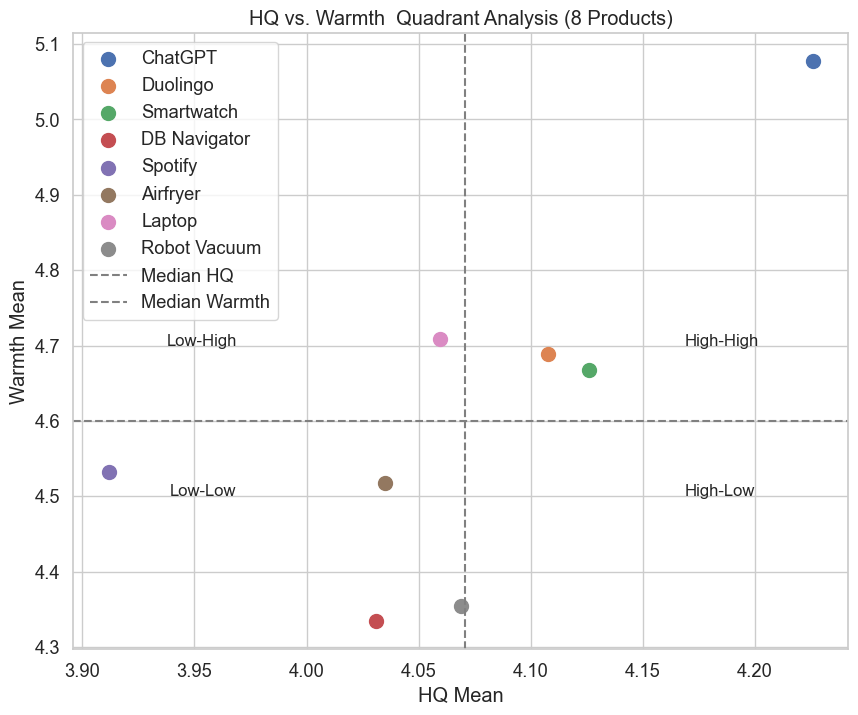

In [59]:
plt.figure(figsize=(10, 8))
for product in products:
    warmth_mean = df_clean[f'Warmth_{product}'].mean()
    hq_mean = (df_clean[f'HQ_I_{product}'].mean() + df_clean[f'HQ_S_{product}'].mean()) / 2
    plt.scatter(hq_mean, warmth_mean,  s=100, label=product)

warmth_median = df_clean[[f'Warmth_{product}' for product in products]].mean().median()
hq_median = (
    df_clean[[f'HQ_I_{product}' for product in products]].mean().mean() +
    df_clean[[f'HQ_S_{product}' for product in products]].mean().mean()
) / 2

plt.axvline(hq_median, color='gray', linestyle='--', label='Median HQ')
plt.axhline(warmth_median, color='gray', linestyle='--', label='Median Warmth')


plt.text(hq_mean + 0.1, warmth_median + 0.1,  'High-High', fontsize=12, ha='left')
plt.text(hq_mean - 0.1, warmth_median + 0.1, 'Low-High',  fontsize=12, ha='right')
plt.text(hq_mean + 0.1, warmth_median - 0.1, 'High-Low',  fontsize=12, ha='left')
plt.text(hq_mean - 0.1, warmth_median - 0.1, 'Low-Low',   fontsize=12, ha='right')

plt.ylabel('Warmth Mean')
plt.xlabel('HQ Mean')
plt.title('HQ vs. Warmth  Quadrant Analysis (8 Products)')
plt.legend()
plt.grid(True)

plt.savefig('warmth_vs_HQ_scatter.png')
plt.show()

### Demographics Visuals

#### Pre-Processing

In [60]:
demo_cols = ['DEMOGENDER', 'DEMOAGe', 'DEMOACAD', 'DEMONAt', 'DEMOPROFEs'] 
# 'DEMOGENDER' = Gender , 'DEMOAGe'= Age, 'DEMOACAD'= Academic Level, 'DEMONAt'= Nationality, 'DEMOPROFEs' = Profession

# Create subset
df_demo = df[demo_cols]

sns.set(style="whitegrid", font_scale=1.2)

# --- Step 1: Clean country names ---
df_demo['DEMONAt'] = df_demo['DEMONAt'].str.strip().str.lower()  # normalize
df_demo['DEMONAt'] = df_demo['DEMONAt'].replace({
    'pakistan': 'Pakistan',
    'pakistani': 'Pakistan',
    'india': 'India',
    'indian': 'India',
    'bangladesh': 'Bangladesh',
    'bangladeshi': 'Bangladesh',
    'bangladesch': 'Bangladesh'
})
df_demo['DEMONAt'] = df_demo['DEMONAt'].str.title()  # capitalize properly

C:\Users\ABC-HP\AppData\Local\Temp\ipykernel_18608\2280530133.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo['DEMONAt'] = df_demo['DEMONAt'].str.strip().str.lower()  # normalize
C:\Users\ABC-HP\AppData\Local\Temp\ipykernel_18608\2280530133.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demo['DEMONAt'] = df_demo['DEMONAt'].replace({
C:\Users\ABC-HP\AppData\Local\Temp\ipykernel_18608\2280530133.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

#### Demographics Overview

C:\Users\ABC-HP\AppData\Local\Temp\ipykernel_18608\389985243.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=gender_counts.values, y=gender_counts.index, palette="Set2", ax=axes[0])
C:\Users\ABC-HP\AppData\Local\Temp\ipykernel_18608\389985243.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=edu_counts.values, y=edu_counts.index, palette="Set3", ax=axes[2])


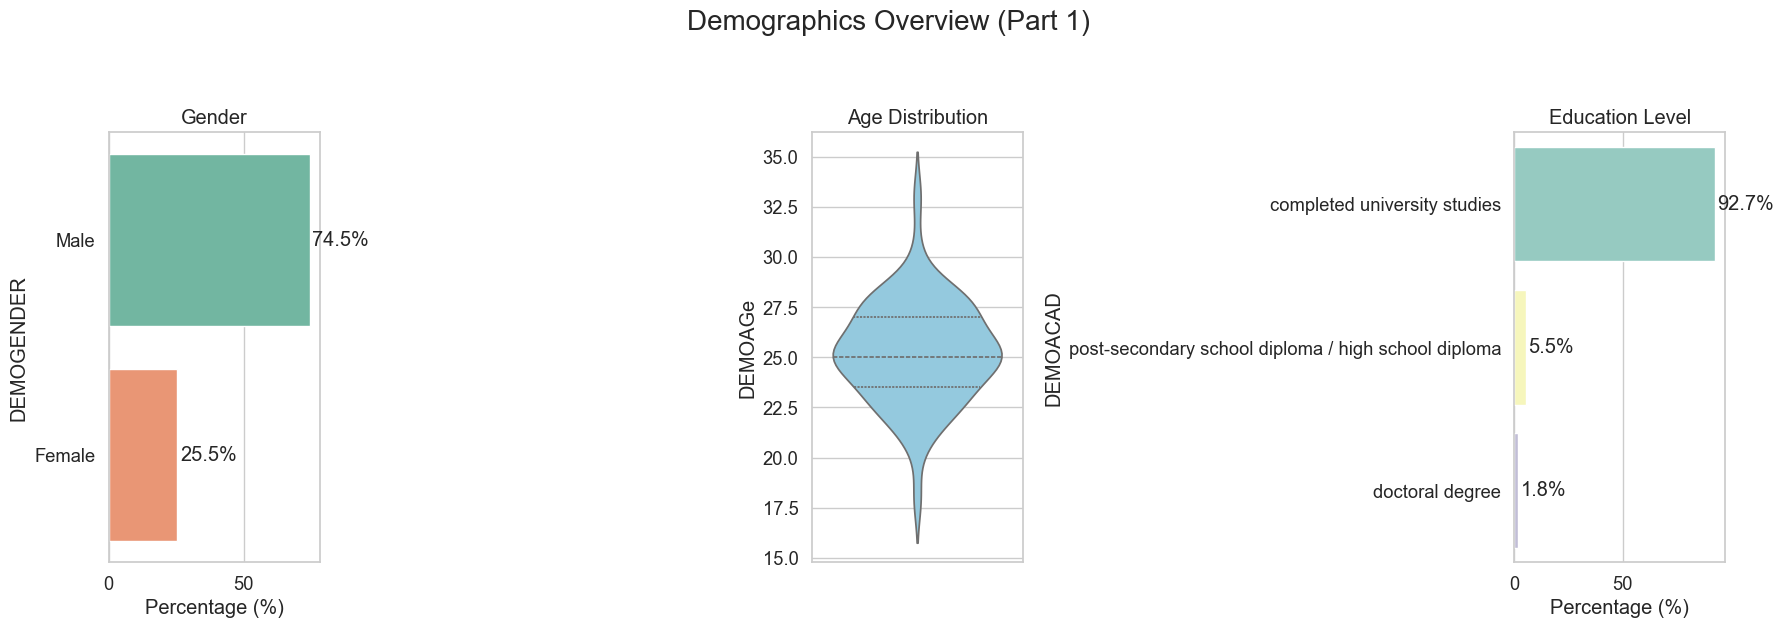

In [61]:
# Image 1
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Demographics Overview (Part 1)", fontsize=20, y=1.05)

# Gender
gender_counts = df_demo['DEMOGENDER'].value_counts(normalize=True) * 100
sns.barplot(x=gender_counts.values, y=gender_counts.index, palette="Set2", ax=axes[0])
axes[0].set_xlabel("Percentage (%)")
axes[0].set_title("Gender")
for i, v in enumerate(gender_counts.values):
    axes[0].text(v + 1, i, f"{v:.1f}%", va='center')

# Age
sns.violinplot(y='DEMOAGe', data=df_demo, ax=axes[1], color="skyblue", inner="quartile")
axes[1].set_title("Age Distribution")
axes[1].set_xlabel("")

# Education
edu_counts = df_demo['DEMOACAD'].value_counts(normalize=True) * 100
sns.barplot(x=edu_counts.values, y=edu_counts.index, palette="Set3", ax=axes[2])
axes[2].set_xlabel("Percentage (%)")
axes[2].set_title("Education Level")
for i, v in enumerate(edu_counts.values):
    axes[2].text(v + 1, i, f"{v:.1f}%", va='center')

plt.tight_layout()
fig.savefig("demographics_part1.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)

C:\Users\ABC-HP\AppData\Local\Temp\ipykernel_18608\4147569246.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="Set1", ax=axes[0])
C:\Users\ABC-HP\AppData\Local\Temp\ipykernel_18608\4147569246.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_prof.values, y=top_prof.index, palette="Pastel1", ax=axes[1])


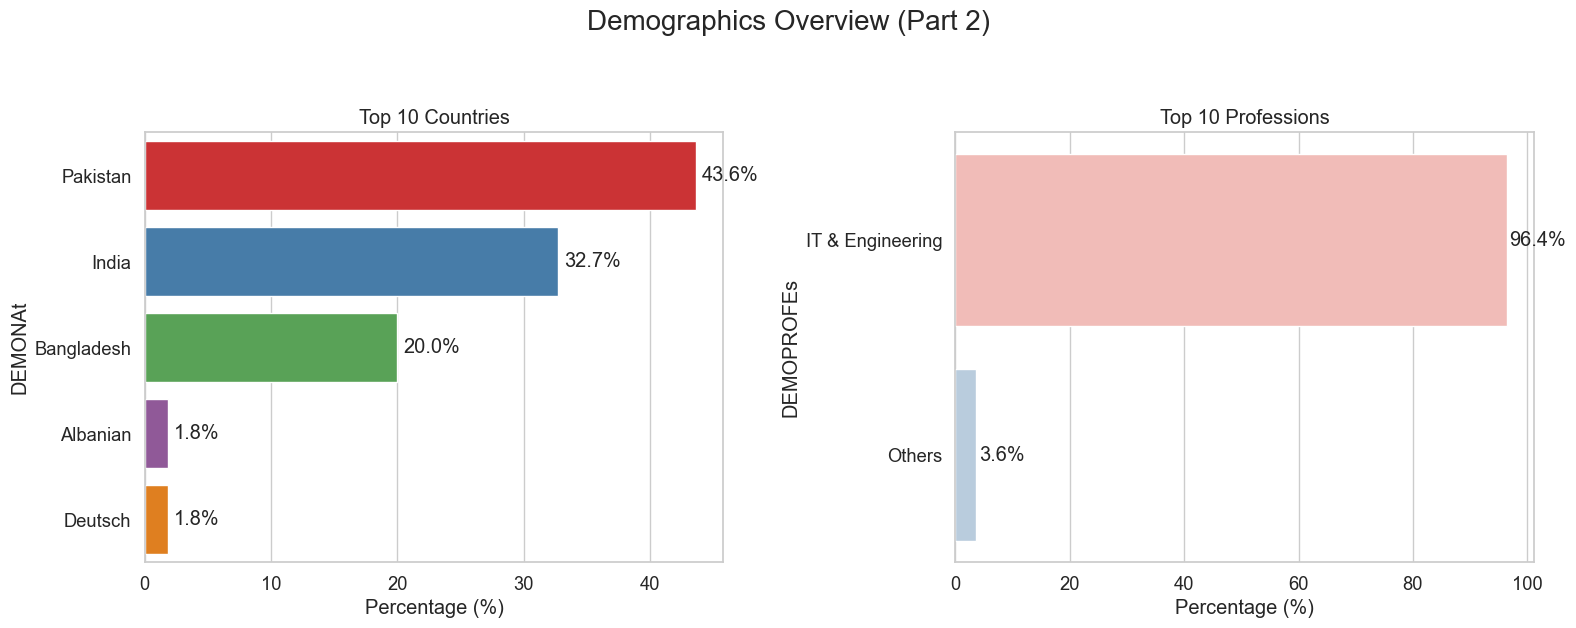

In [62]:
# Image 2
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Demographics Overview (Part 2)", fontsize=20, y=1.05)

# Country
country_counts = df_demo['DEMONAt'].value_counts(normalize=True) * 100
top_countries = country_counts.nlargest(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette="Set1", ax=axes[0])
axes[0].set_xlabel("Percentage (%)")
axes[0].set_title("Top 10 Countries")
for i, v in enumerate(top_countries.values):
    axes[0].text(v + 0.5, i, f"{v:.1f}%", va='center')

# Profession
prof_counts = df_demo['DEMOPROFEs'].value_counts(normalize=True) * 100
top_prof = prof_counts.nlargest(10)
sns.barplot(x=top_prof.values, y=top_prof.index, palette="Pastel1", ax=axes[1])
axes[1].set_xlabel("Percentage (%)")
axes[1].set_title("Top 10 Professions")
for i, v in enumerate(top_prof.values):
    axes[1].text(v + 0.5, i, f"{v:.1f}%", va='center')

plt.tight_layout()
fig.savefig("demographics_part2.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close(fig)